In [13]:
# Import libraries
import tensorflow                     as tf
from tensorflow.keras import backend  as K
import lightgbm                      as lgb
import matplotlib.pyplot              as plt
import pandas                         as pd
import numpy                          as np
import sklearn.metrics                as metrics
import time

from sklearn.preprocessing          import StandardScaler
from sklearn.model_selection        import train_test_split, GridSearchCV
from sklearn.tree                   import DecisionTreeRegressor
from sklearn.ensemble               import RandomForestRegressor
from sklearn.linear_model           import LinearRegression
from sklearn.linear_model           import Ridge

/usr/local/lib/python3.10/dist-packages/dask/dataframe/__init__.py:42: FutureWarning: 
Dask dataframe query planning is disabled because dask-expr is not installed.

You can install it with `pip install dask[dataframe]` or `conda install dask`.
This will raise in a future version.

  warnings.warn(msg, FutureWarning)


# Data Preparation

In [14]:
# Through Google Drive
#from google.colab import drive
#drive.mount('/content/drive')
#
#train_url = r"/content/drive/MyDrive/preprocessed_dataset/train_dataset.csv"
#val_url = r"/content/drive/MyDrive/preprocessed_dataset/validation_dataset.csv"
#test_url = r"/content/drive/MyDrive/preprocessed_dataset/test_dataset.csv"

Mounted at /content/drive


In [15]:
# Locally
train_url = r"preprocessed_dataset\train_dataset.csv"
val_url = r"preprocessed_dataset\train_dataset.csv"
test_url = r"preprocessed_dataset\test_dataset.csv"

In [17]:
# Load data
train_df = pd.read_csv(train_url)
val_df = pd.read_csv(val_url)

train_df.head()

,date,store_nbr,sales,onpromotion,oil_price,cluster,WageDay,year date,month date,day date,...,state_10,state_11,state_12,state_13,state_14,state_15,type_y_1,type_y_2,type_y_3,type_y_4
0,2013-01-01,9,0.0,0,93.13,6,0,2013,1,1,...,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
1,2013-01-01,11,0.0,0,93.13,6,0,2013,1,1,...,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
2,2013-01-01,43,0.0,0,93.13,10,0,2013,1,1,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
3,2013-01-01,37,0.0,0,93.13,2,0,2013,1,1,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
4,2013-01-01,33,0.0,0,93.13,3,0,2013,1,1,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0


In [18]:
X_train = train_df.drop(["sales", "date"], axis=1).to_numpy()
y_train = train_df["sales"].to_numpy()

X_val = val_df.drop(["sales", "date"], axis=1).to_numpy()
y_val = val_df["sales"].to_numpy()

X_train.shape, y_train.shape

((1498228, 118), (1498228,))

In [19]:
from sklearn.feature_selection import mutual_info_regression

def feature_importance(X_train, y_train, limit_rows=10000,top_features=5):
  mutual_info = mutual_info_regression(X_train[:limit_rows], y_train[:limit_rows])
  mutual_df = pd.DataFrame({
     "Features": pd.Series(train_df.drop(["sales", "date"], axis=1).columns),
     "Mutual_Gain": mutual_info
  })
  return mutual_df.sort_values(by="Mutual_Gain", ascending=False).head(top_features)

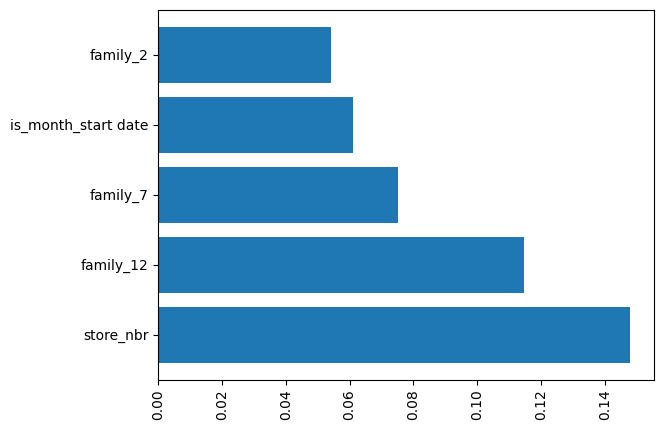

In [20]:
importance_df = feature_importance(X_train, y_train)
plt.barh(importance_df["Features"], importance_df["Mutual_Gain"])
plt.xticks(rotation=90)
plt.show()

In [22]:
# Function for evaluating our model
def evaluate_model(y_pred, y_true):
    MAE = metrics.mean_absolute_error(y_true, y_pred)
    MSE = metrics.mean_squared_error(y_true, y_pred)
    RMSE = metrics.mean_squared_error(y_true, y_pred, squared=True)
    R2_SCORE = metrics.r2_score(y_true, y_pred)
    MAX_ERROR = metrics.max_error(y_true, y_pred)
    MAPE = metrics.mean_absolute_percentage_error(y_true, y_pred)

    results = {
        "MAE": MAE,
        "MSE": MSE,
        "RMSE": RMSE,
        "MAX_ERROR": MAX_ERROR,
        "MAPE": MAPE,
        "R2": R2_SCORE}

    return results


# Let's make a function that will run our baseline models
def run_models(models, X_train, y_train, X_val, y_val):
  results = {}
  for model_name, model in models.items():
    if model_name == "model_5":
      y_pred = run_lightgbm(X_train, y_train, X_val, y_val)
      results[model_name] = evaluate_model(y_pred, y_val)
      continue

    print(f"Running {model_name}")
    start_time = time.time()
    model.fit(X_train, y_train)
    y_pred = model.predict(X_val)
    results[model_name] = evaluate_model(y_pred, y_val)
    finish_time = time.time()
    print(f"{model_name} took {finish_time - start_time} seconds to run")

  return results

In [23]:
# Create LightGBB function for training
def run_lightgbm(X_train, y_train, X_val, y_val):
  """
  This function trains a LightGBM model on the given training data and evaluates it on the validation data.

  Returns:
    numpy.ndarray: The predicted target values for the validation data.
  """
  train_data = lgb.Dataset(X_train, label=y_train)
  val_data = lgb.Dataset(X_val, label=y_val, reference=train_data)

  # Define the parameters for the LightGBM model
  params = {
      'objective': 'regression',      # Defines the task type as regression
      'metric': 'rmse',               # Evaluation metric as root mean squared error
      'boosting_type': 'gbdt',        # Boosting type as Gradient Boosting Decision Tree
      'num_leaves': 31,               # Maximum number of leaves in one tree
      'learning_rate': 0.05,          # Step size for each iteration
      'feature_fraction': 0.9         # Fraction of features to be randomly selected for each tree
  }

  # Train the model
  bst = lgb.train(params, train_data, num_boost_round=100, valid_sets=[val_data])

  # Make predictions
  y_pred = bst.predict(X_val, num_iteration=bst.best_iteration)

  return y_pred

In [24]:
models = {
    "model_1": RandomForestRegressor(n_estimators=30, max_depth=10, random_state=42),
    "model_2": Ridge(),
    "model_3": LinearRegression(),
    "model_4": DecisionTreeRegressor(),
    "model_5": "LightGBM"
}

results = run_models(models, X_train, y_train, X_val, y_val)
results = pd.DataFrame(results)
results.T

Running model_1
model_1 took 363.6765594482422 seconds to run
Running model_2
model_2 took 2.6252174377441406 seconds to run
Running model_3
model_3 took 25.04971480369568 seconds to run
Running model_4
model_4 took 53.955326795578 seconds to run
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.193144 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 847
[LightGBM] [Info] Number of data points in the train set: 1498228, number of used features: 118
[LightGBM] [Info] Start training from score 447.305448


,MAE,MSE,RMSE,MAX_ERROR,MAPE,R2
model_1,167.969229,310565.549828,310565.549828,121352.193837,5.596465e+16,0.828560
model_2,375.412313,740927.279099,740927.279099,119899.484365,1.700197e+17,0.590989
model_3,375.413888,740925.080160,740925.080160,119899.453125,1.700279e+17,0.590990
model_4,130.613440,355606.580236,355606.580236,120254.000000,1.255115e+16,0.803696
model_5,195.117862,316141.176073,316141.176073,120410.868812,5.623679e+16,0.825482


# Making predictions using ensemble models

In [25]:
def ensemble_models(model, X_train, y_train, X_val, y_val, num_iters=8):
  """
  Iterates and trains the given model for num_iters times.

  Returns:
    Array of models.

  """

  ensemble_of_models = []
  print(f"Running training process...")
  for i in range(num_iters):
    time_start = time.time()
    model.fit(X_train, y_train)
    ensemble_of_models.append(model)
    time_end = time.time()
    print(f"Model {i} took {time_end - time_start} seconds to run")

  return ensemble_of_models

def predict_ensemble_models(models, X_val):
  """
  Predicting y_val using ensemble_models.

  Returns:
    Mean of predictions.
  """

  predictions = []
  for model in models:
    predictions.append(model.predict(X_val))
  return np.mean(predictions, axis=0)


In [26]:
ensemble_of_models = ensemble_models(DecisionTreeRegressor(), X_train, y_train, X_val, y_val, num_iters=5)
y_pred = predict_ensemble_models(ensemble_of_models, X_val)
ensemble_results = evaluate_model(y_pred, y_val)
results["model_6"] = ensemble_results
results.T

Running training process...
Model 0 took 53.427982807159424 seconds to run
Model 1 took 52.75167989730835 seconds to run
Model 2 took 51.6045503616333 seconds to run
Model 3 took 53.65156412124634 seconds to run
Model 4 took 53.169843673706055 seconds to run


,MAE,MSE,RMSE,MAX_ERROR,MAPE,R2
model_1,167.969229,310565.549828,310565.549828,121352.193837,5.596465e+16,0.828560
model_2,375.412313,740927.279099,740927.279099,119899.484365,1.700197e+17,0.590989
model_3,375.413888,740925.080160,740925.080160,119899.453125,1.700279e+17,0.590990
model_4,130.613440,355606.580236,355606.580236,120254.000000,1.255115e+16,0.803696
model_5,195.117862,316141.176073,316141.176073,120410.868812,5.623679e+16,0.825482
model_6,130.968965,363883.459619,363883.459619,120755.000000,1.277105e+16,0.799127


  # Predicting Test Data

 **We are going to use the best model from all, so we get the best performance**

In [27]:
models = {
    "model_1": RandomForestRegressor(n_estimators=30, max_depth=10, random_state=42),
    "model_2": Ridge(),
    "model_3": LinearRegression(),
    "model_4": DecisionTreeRegressor(),
    "model_5": "LightGBM",
    "model_6": "Ensemble Of Models"
}

In [28]:
best_model = results.T.sort_values(by="MAE", ascending=True).iloc[0].name
models[best_model]

DecisionTreeRegressor()

In [29]:
test_dataset = pd.read_csv(test_url)
test_dataset.drop(["date", "sales"], axis=1, inplace=True) # sales are coming from the alignment, but naturally doesn't give any informational gain.
test_dataset = test_dataset.to_numpy()

test_dataset.shape

(28512, 118)

# Predict on test data and post it in Kaggle

In [30]:
# Upload your kaggle.json
# -----------------------------------------
from google.colab import files         #  -
files.upload()                         #  -
# -----------------------------------------

KeyboardInterrupt: 

In [31]:
!pip install kaggle
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json
# Get sample_submission for "id" column
!kaggle competitions download -c store-sales-time-series-forecasting -f sample_submission.csv -p .

sample_submission.csv: Skipping, found more recently modified local copy (use --force to force download)


In [33]:
test_preds = predict_ensemble_models(ensemble_of_models, test_dataset)
len(test_preds)

28512

In [34]:
id_column = pd.read_csv("sample_submission.csv")["id"]
id_column

0        3000888
1        3000889
2        3000890
3        3000891
4        3000892
          ...   
28507    3029395
28508    3029396
28509    3029397
28510    3029398
28511    3029399
Name: id, Length: 28512, dtype: int64

In [35]:
# Convert predictions into csv file
submission = pd.DataFrame({
    "id": id_column,
    "sales": test_preds
})

submission.to_csv("submission.csv", index=False)


In [36]:
submission.head()

,id,sales
0,3000888,5.0
1,3000889,0.0
2,3000890,7.0
3,3000891,2344.0
4,3000892,0.0


In [37]:
!kaggle competitions submit -c store-sales-time-series-forecasting -f submission.csv -m "Summer Project 2024 is Done"

100% 382k/382k [00:00<00:00, 557kB/s] 
Successfully submitted to Store Sales - Time Series Forecasting